 # ATSC 409 Project

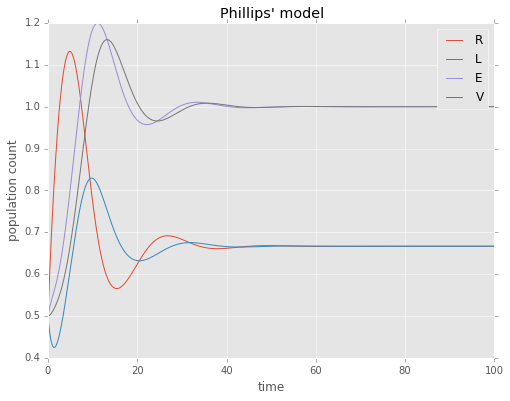

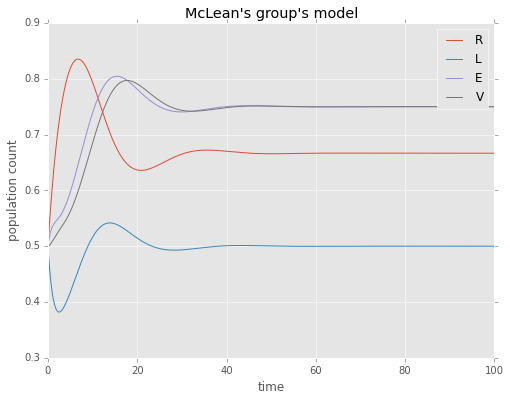

In [3]:
%matplotlib inline
from collections import namedtuple
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
import yaml

def rkck_init():
    # % initialize the Cash-Karp coefficients
    # % defined in the tableau in lab 4,
    # % section "Embedded Runge Kutta"
    a = np.array([0.2, 0.3, 0.6, 1.0, 0.875])
    # c1 coefficients for the fifth order scheme
    c1 = np.array([37.0 / 378.0, 0.0, 250.0 / 621.0,
                   125.0 / 594.0, 0.0, 512.0 / 1771.0])
    # c2=c* coefficients for the fourth order schme
    c2 = np.array([2825.0 / 27648.0, 0.0, 18575.0 / 48384.0,
                   13525.0 / 55296.0, 277.0 / 14336.0, .25])
    b = np.empty([5, 5], 'float')
    # the following line is ci - ci* in lab4, \Delta_est equationl
    # this is used to calculate \Delta_est = estError for the embededd
    # Runge Kutta  \sum_^6 (c_i -c_i^*)
    c2 = c1 - c2
    # this sets b values for same tableu 
    b[0, 0] = 0.2
    b[1, 0] = 3.0 / 40.0
    b[1, 1] = 9.0 / 40.0
    b[2, 0] = 0.3
    b[2, 1] = -0.9
    b[2, 2] = 1.2
    b[3, 0] = -11.0 / 54.0
    b[3, 1] = 2.5
    b[3, 2] = -70.0 / 27.0
    b[3, 3] = 35.0 / 27.0
    b[4, 0] = 1631.0 / 55296.0
    b[4, 1] = 175.0 / 512.0
    b[4, 2] = 575.0 / 13824.0
    b[4, 3] = 44275.0 / 110592.0
    b[4, 4] = 253.0 / 4096.0
    return (a, c1, c2, b)
    
class Integrator:

    def set_yinit(self,initvars,uservars,timevars):
        ### uservars: parameters
        if uservars:
            self.config['uservars'].update(uservars)
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        ### initvars: x y z a
        if initvars:
            self.config['initvars'].update(initvars)
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        ### timevars is not really used here
        if timevars:
            self.config['timevars'].update(timevars)
        timevars = namedtuple('timevars', self.config['timevars'].keys())
        self.timevars = timevars(**self.config['timevars'])
        self.yinit = np.array([self.initvars.x, self.initvars.y, 
                               self.initvars.z, self.initvars.a])
        self.nvars = len(self.yinit)

    def __init__(self, coeffFileName):
        with open(coeffFileName, 'rb') as f:
            config = yaml.load(f)
        self.config = config
        # read in dt tstart tend
        timevars = namedtuple('timevars',config['timevars'].keys())
        self.timevars = timevars(**config['timevars'])
        # read in dtpassmin dtpassmax dtfailmin dtfailmax s rtol atol maxsteps maxfail
        adaptvars = namedtuple('adaptvars', config['adaptvars'].keys())
        self.adaptvars = adaptvars(**config['adaptvars'])
        self.rkckConsts = rkck_init()

    def __str__(self):
        out = 'integrator instance with attributes initvars, timevars,uservars, ' + \
            'adaptvars'
        return out

    def derivs(self, y, t):
        raise ValueError('derivs needs to be overrideen in the derived class')
        return None

    def rkckODE(self, yold, timeStep, deltaT):
        # initialize the Cash-Karp coefficients
        # defined in the tableau in lab 4,
        a, c1, c2, b = self.rkckConsts
        i = self.initvars
        # set up array to hold k values in lab4 
        derivArray = np.empty([6, self.nvars], 'float')
        ynext = np.zeros_like(yold)
        bsum = np.zeros_like(yold)
        estError = np.zeros_like(yold)
        # vector k1 in lab4 equation 3.9
        derivArray[0, :] = self.derivs(yold, timeStep)[:]
        # calculate step
        # c1=c_i in lab 4 notation, but c2=c_i - c^*_i
        y = yold
        for i in np.arange(5):
            bsum = 0.
            for j in np.arange(i + 1):
                bsum = bsum + b[i, j] * derivArray[j, :]
            # vectors k2 through k6 in lab4 
            # pdb.set_trace()
            derivArray[i + 1, :] = self.derivs(y + deltaT * bsum, timeStep + a[i] * deltaT)[:]
            # partial sum of error in lab4 \Delta_est
            #  sum the error term
            estError = estError + c2[i] * derivArray[i, :]
            # print "estError: ",estError
            # 5th order estimate y_{n+1}
            ynext = ynext + c1[i] * derivArray[i, :]
        # final fifth order anser
        y = y + deltaT * (ynext + c1[5] * derivArray[5, :])
        # final 4th order estimate estimate
        estError = deltaT * (estError + c2[5] * derivArray[5, :])
        # print "estError final: ",estError
        timeStep = timeStep + deltaT
        # pdb.set_trace()
        return (y, estError, timeStep)

    def timeloopfixed(self):
        """fixed time step with estimated errors"""
        t = self.timevars
        yold = self.yinit
        yError = np.zeros_like(yold)
        yvals = [yold]
        errorList = [yError]
        timeSteps = np.arange(t.tstart, t.tend, t.dt)
        for theTime in timeSteps[:-1]:
            yold, yError, newTime = self.rkckODE(yold, theTime, t.dt)
            yvals.append(yold)
            errorList.append(yError)
        yvals = np.array(yvals).squeeze()
        errorVals = np.array(errorList).squeeze()
        return (timeSteps, yvals, errorVals)
        
class Integ(Integrator):
    def __init__(self, coeff_file_name,initvars=None,uservars=None,
                timevars=None):
        super().__init__(coeff_file_name)
        self.set_yinit(initvars,uservars,timevars)

##### Create an integrator subclass for Phillips' model.       
class IntegP(Integ):    
    def derivs(self, coords, t):
        x,y,z,a = coords
        u = self.uservars
        f = np.empty_like(coords)
        f[0] = u.gamma/(1 + u.chi*a) - u.mu*x - u.beta*x*a
        f[1] = u.prob*x*a - (u.alpha + u.mu)*y
        f[2] = (1 - u.prob)*u.beta*x*a + u.alpha*y - u.delta*z
        f[3] = u.pi*z - u.sigma*a
        return f
        
##### Create an integrator subclass for McLean's group's model.
class IntegM(Integ):
    def derivs(self, coords, t):
        x,y,z,a = coords
        u = self.uservars
        f = np.empty_like(coords)
        f[0] = u.gamma*u.tau - u.mu*x - u.beta*x*a
        f[1] = u.prob*x*a - (u.alpha + u.mu)*y
        f[2] = (1 - u.prob)*u.beta*x*a + u.alpha*y - u.delta*z
        f[3] = u.pi*z - u.sigma*a
        return f
        
##### Define the parameter values and initial conditions.
timevars=dict(tstart=0,tend=100,dt=0.01)
uservars=dict(gamma=0.5, tau=0.5, mu=0, beta=0.5, prob=0.5, alpha=0.5, delta=0.5, pi=0.5, sigma=0.5, chi=0.5)
initvars=dict(x=0.5,y=0.5,z=0.5,a=0.5)
params=dict(timevars=timevars,uservars=uservars,initvars=initvars)

##### Numerically solve Phillips' equations.
theSolver = IntegP('project.yaml',**params)
timevals, coords, errorlist = theSolver.timeloopfixed()
xvals,yvals,zvals,avals=coords[:,0],coords[:,1],coords[:,2],coords[:,3]

##### Numerically solve McLean's group's solutions.
theSolver2 = IntegM('project.yaml',**params)
timevals2, coords2, errorlist2 = theSolver2.timeloopfixed()
xvals2,yvals2,zvals2,avals2=coords2[:,0],coords2[:,1],coords2[:,2],coords2[:,3]

##### Create a plot for Phillips' model.
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(timevals,xvals,label='R')
ax.plot(timevals,yvals,label='L')
ax.plot(timevals,zvals,label='E')
ax.plot(timevals,avals,label='V')
ax.set(title="Phillips' model",xlabel='time',ylabel='population count')
out=ax.legend()

##### Create a plot for McLean's group's model.
fig2,ax2 = plt.subplots(1,1,figsize=(8,6))
ax2.plot(timevals2,xvals2,label='R')
ax2.plot(timevals2,yvals2,label='L')
ax2.plot(timevals2,zvals2,label='E')
ax2.plot(timevals2,avals2,label='V')
ax2.set(title="McLean's group's model",xlabel='time',ylabel='population count')
out=ax2.legend()